In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.utils import resample


In [2]:
pbp = pd.read_csv('../../Data/play-by-play/pbp_exp12.csv')

In [ ]:
# List of categorical columns
categorical_cols = [
    'OffenseTeam', 'DefenseTeam', 'play_type', 'side_of_field', 'stadium', 
    'play_type_nfl', 'roof', 'surface_type', 'home_team', 'away_team', 
    'season_type', 'offense_formation', 'temperature_grade', 'temperature_bucket'
]

# Dictionary to hold LabelEncoders for each column
label_encoders = {}

# Apply LabelEncoder to each categorical column and store encoders
for col in categorical_cols:
    le = LabelEncoder()
    pbp[col] = le.fit_transform(pbp[col].astype(str))  # Ensure the column is treated as a string
    label_encoders[col] = le 

In [4]:
X = pbp[['week', 'OffenseTeam', 'DefenseTeam', 'Down', 'YardsToGo', 'yardline_100', 'play_type',
               'Quarter', 'game_seconds_remaining', 'game_half', 'drive', 'series', 'score_differential',
               'stadium', 'roof', 'surface_type', 'HOME_day_since_last_game', 'AWAY_day_since_last_game',
               'total_play_count', 'home_team_on_offense', 'home_team_on_defense', 'season_progression',
               'defenders_in_box', 'offense_formation', 'Temperature', 'Precipitation', 'goal_line_situation',
               'pass_count', 'run_count', 'current_defence_rank','temperature_grade', 'epa', 
               'late_season','is_close_game', 'poor_field_condition', 'rest_differential', 'blitz_situation',
               'short_rest','pass_run_ratio', 'offensive_predictability', 'fourth_down_attempt', 'third_and_long']]


y = pbp['Player-Injured-On-Play']

## Graphing Scikit-learn Feature Importance

In [5]:
k = 53  
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists for storing metrics and models
accuracy_scores, precision_scores, recall_scores = [], [], []
false_positive_cases, false_negative_cases = [], []
fold_models = {}
feature_importances = np.zeros(X.shape[1])


# --- Cross-Validation Loop ---
for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Separate injured and non-injured plays
    X_train_pos = X_train[y_train == 1]
    X_train_neg = X_train[y_train == 0]
    y_train_pos = y_train[y_train == 1]
    y_train_neg = y_train[y_train == 0]

    X_test_pos = X_test[y_test == 1]
    X_test_neg = X_test[y_test == 0]
    y_test_pos = y_test[y_test == 1]
    y_test_neg = y_test[y_test == 0]

    # Resample to ensure balance
    X_train_pos_resampled, y_train_pos_resampled = resample(X_train_pos, y_train_pos, replace=True, n_samples=1619, random_state=42)
    X_train_neg_resampled, y_train_neg_resampled = resample(X_train_neg, y_train_neg, replace=False, n_samples=1619, random_state=42)

    X_test_pos_resampled, y_test_pos_resampled = resample(X_test_pos, y_test_pos, replace=True, n_samples=1619, random_state=42)
    X_test_neg_resampled, y_test_neg_resampled = resample(X_test_neg, y_test_neg, replace=False, n_samples=1619, random_state=42)

    # Combine resampled data
    X_train_resampled = pd.concat([X_train_pos_resampled, X_train_neg_resampled])
    y_train_resampled = pd.concat([y_train_pos_resampled, y_train_neg_resampled])

    X_test_resampled = pd.concat([X_test_pos_resampled, X_test_neg_resampled])
    y_test_resampled = pd.concat([y_test_pos_resampled, y_test_neg_resampled])

    # Train Decision Tree
    dt_model = DecisionTreeClassifier(random_state=42, max_depth=6)
    dt_model.fit(X_train_resampled, y_train_resampled)

    # Predict & Evaluate
    y_pred = dt_model.predict(X_test_resampled)
    accuracy_scores.append(accuracy_score(y_test_resampled, y_pred))
    precision_scores.append(precision_score(y_test_resampled, y_pred))
    recall_scores.append(recall_score(y_test_resampled, y_pred))

    # Identify misclassified cases
    test_df = X_test_resampled.copy()
    test_df['Predicted'] = y_pred
    test_df['Actual'] = y_test_resampled
    test_df['Fold'] = fold

    # Store the trained model
    fold_models[fold] = [dt_model, test_df]

    # Store feature importances
    feature_importances += dt_model.feature_importances_


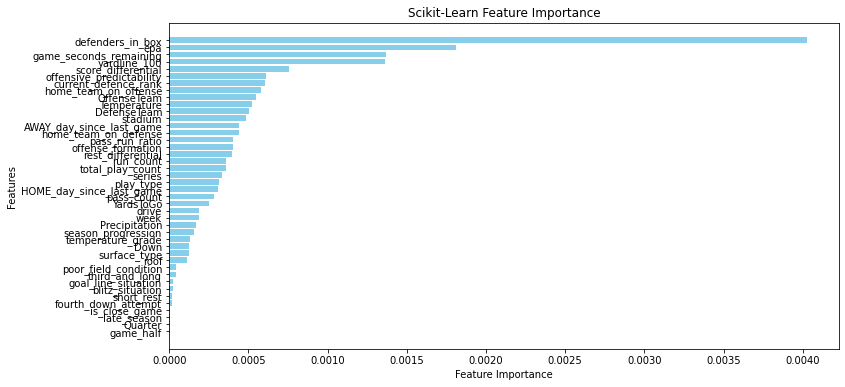

<Figure size 432x288 with 0 Axes>

In [ ]:
# Compute average feature importance
feature_importances /= k

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importances = feature_importances[sorted_indices]

# Plot feature importances
plt.figure(figsize=(12, 6), facecolor='white')
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Scikit-Learn Feature Importance')
plt.gca().invert_yaxis()
plt.show()


## Graphing Our Feature Importance Score

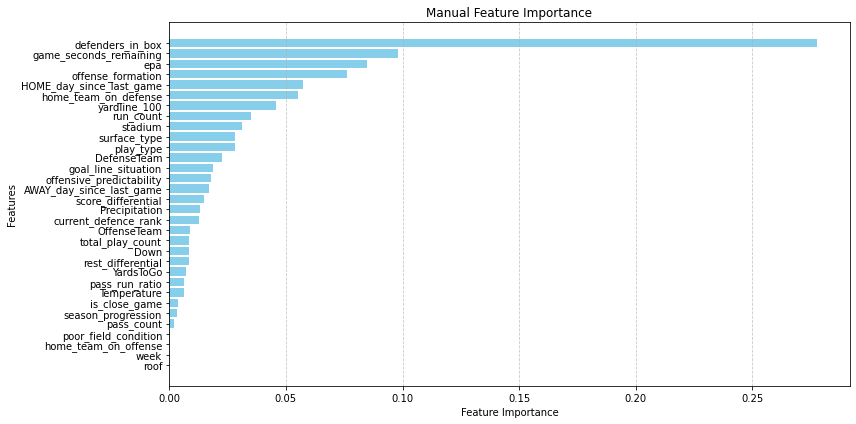

<Figure size 432x288 with 0 Axes>

In [ ]:
data = {
    "Feature": [
        "defenders_in_box", "game_seconds_remaining", "epa", "offense_formation", "HOME_day_since_last_game",
        "home_team_on_defense", "yardline_100", "run_count", "stadium", "surface_type", "play_type",
        "DefenseTeam", "goal_line_situation", "offensive_predictability", "AWAY_day_since_last_game",
        "score_differential", "Precipitation", "current_defence_rank", "OffenseTeam", "total_play_count",
        "Down", "rest_differential", "YardsToGo", "pass_run_ratio", "Temperature", "is_close_game",
        "season_progression", "pass_count", "poor_field_condition", "home_team_on_offense", "week", "roof"
    ],
    "Normalised Feature Score": [
        0.277731003, 0.098024285, 0.084824094, 0.076206434, 0.057259907,
        0.055265898, 0.04595027, 0.035218862, 0.031067898, 0.028225875, 0.028073306,
        0.022664081, 0.018597881, 0.017979393, 0.017111009,
        0.014832861, 0.013222287, 0.012974388, 0.008883034, 0.008625721,
        0.008611173, 0.008563261, 0.007244622, 0.00643575, 0.006210306, 0.003626606,
        0.003267076, 0.002268463, 0.000510303, 0.000268802, 0.000255151, 0.0
    ]
}

# Create DataFrame
df = pd.DataFrame(data)
df_sorted = df.sort_values(by="Normalised Feature Score", ascending=True)

plt.figure(figsize=(12, 6), facecolor='White')
plt.barh(df_sorted["Feature"], df_sorted["Normalised Feature Score"], color="skyblue")
plt.xlabel("Feature Importance")
plt.ylabel('Features')
plt.title("Manual Feature Importance")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()